# Comparison of *revrand*'s algorithms on the SARCOS dataset

In this notebook we test how the GLM in *revrand* performs on the inverse dynamics experiment conducted in Gaussian Processes for Machine Learning, Chapter 8, page 182. In this experiment there are 21 dimensions, and 44,484 training examples. All GP's are using square exponential covariance functions, with a seperate lengthscale for each dimension.

In [8]:
import logging
import numpy as np
from scipy.stats import gamma 

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from revrand import GeneralizedLinearModel, Parameter, Positive
from revrand.basis_functions import RandomRBF
from revrand.likelihoods import Gaussian
from revrand.metrics import smse, msll
from revrand.utils.datasets import fetch_gpml_sarcos_data
from revrand.optimize import Adam, AdaDelta

from plotting import fancy_yyplot
import matplotlib.pyplot as pl
%matplotlib inline

logging.basicConfig(level=logging.INFO)

### Settings

In [9]:
lenscale = gamma(2, scale=50)
regularizer = gamma(2, scale=10)
var = gamma(2, scale=50)
nbases = 512
random_state = 100
nsamples = 10

batch_size = 10
maxiter = int(1e6)
updater = Adam()

doGP = False
m = 1024
n_restarts=1

### Load the data

In [10]:
gpml_sarcos = fetch_gpml_sarcos_data()

X_train = gpml_sarcos.train.data
y_train = gpml_sarcos.train.targets

X_test = gpml_sarcos.test.data
y_test = gpml_sarcos.test.targets

Ntrain, D = X_train.shape

print("Training data shape = {}".format(X_train.shape))
print("Testing data shape = {}".format(X_test.shape))


Training data shape = (44484, 21)
Testing data shape = (4449, 21)


### Transform targets and inputs
As per GPML p23

In [11]:
# Targets
ymean = y_train.mean()
y_train -= ymean
y_test -= ymean

# Inputs
Xscaler = StandardScaler()
Xscaler.fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

### Initialise the algorithms

In [12]:
if not doGP:
    lenscale_init = Parameter(lenscale, Positive(), shape=(D,))
    var_init = Parameter(var, Positive())
    regularizer_init = Parameter(regularizer, Positive())

    base = RandomRBF(nbases=nbases,
                     Xdim=D,
                     lenscale=lenscale_init,
                     random_state=random_state,
                     regularizer=regularizer_init
                    )
    llhood = Gaussian(var=var_init)

    alg = GeneralizedLinearModel(llhood,
                                 base,
                                 updater=updater,
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 nsamples=nsamples,
                                 random_state=random_state
                                )
else:
    kern = 3**2 * RBF(length_scale=np.ones(D), length_scale_bounds=(1e-3, 1e7)) \
        + WhiteKernel(noise_level=1)
    alg = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts)

### Train the algorithms

In [13]:
if not doGP:
    alg.fit(X_train, y_train)
else:
    rnd = np.random.RandomState(random_state)
    t_ind = rnd.choice(Ntrain, size=m, replace=False)
    alg.fit(X_train[t_ind], y_train[t_ind])


INFO:revrand.glm:Optimising parameters...
INFO:revrand.optimize.decorators:Evaluating random starts...
INFO:revrand.glm:Random starts: Iter -500: ELBO = -327177.86699434154, reg = 26.68796252095754, like_hypers = 128.63194666474095, basis_hypers = [ 133.98186912   83.14382722   69.22046829  101.82115024  241.24910791
  138.95555941   95.52607268  336.55119088   56.49825177  115.51929154
   82.2004983    53.48834491  169.0754097   260.75877363   85.60704294
  197.3968828    46.33931996   84.25662107  126.52633985   70.41958317
  225.34293751]
INFO:revrand.optimize.decorators:Best start found with objective = 156185.74545855794
INFO:revrand.glm:Iter 0: ELBO = -285023.3092345732, reg = 19.60797532544373, like_hypers = 107.98028964994161, basis_hypers = [  59.85141055   92.90899248   97.53840642  162.32263605   69.63342191
   38.11699282  176.06884405  146.27274776   23.14897445   83.7642436
  127.68675311  189.79868435   68.20685915   52.79900578   64.43069329
   26.06088441  145.12518454

### Predict and score



SMSE = 0.025241069361478262
MSLL = -1.839671905429531


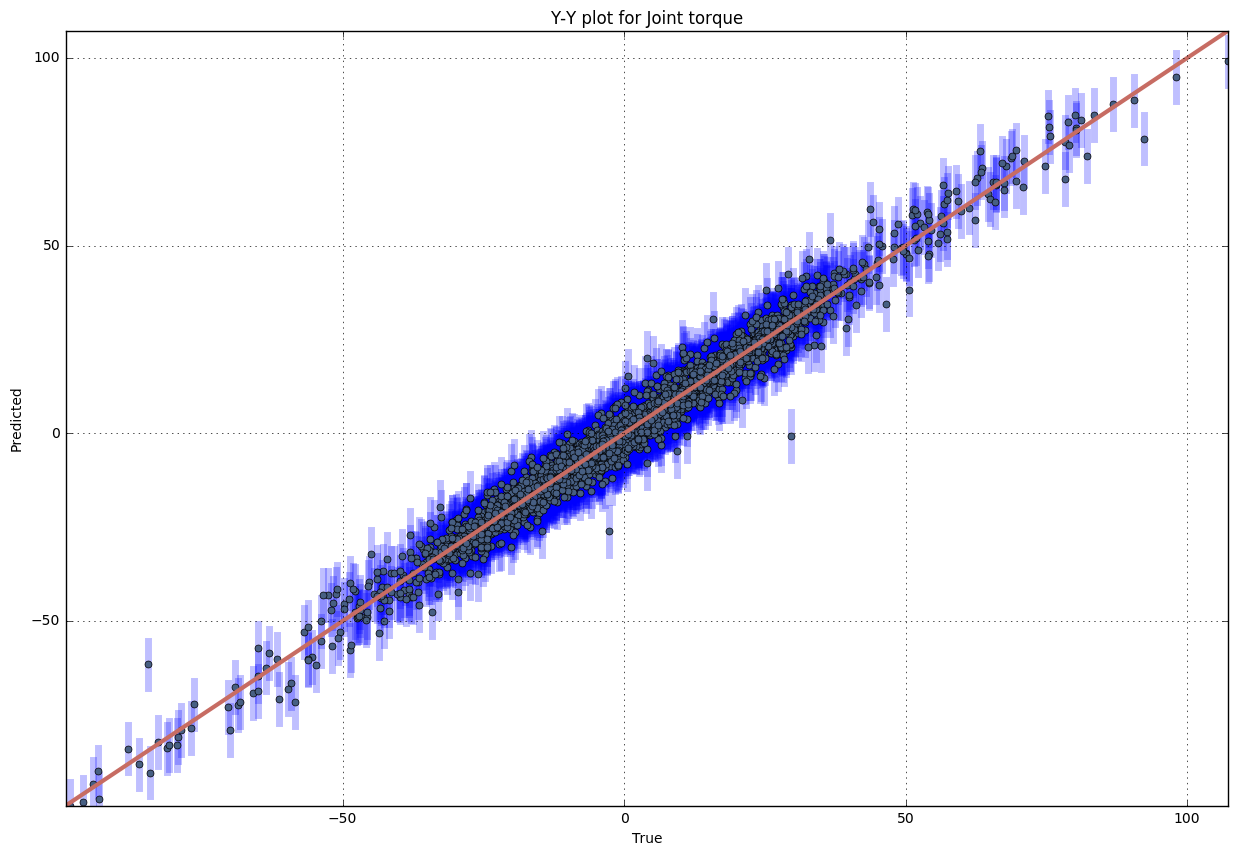

In [14]:
if not doGP:
    Ey, Vf = alg.predict_moments(X_test)
    Vy = Vf + alg.like_hypers_
    Sy = np.sqrt(Vy)
else:
    Ey, Sy = alg.predict(X_test, return_std=True)
    Vy = Sy**2

print("SMSE = {}".format(smse(y_test, Ey)))
print("MSLL = {}".format(msll(y_test, Ey, Vy, y_train)))

# YY plot
pl.figure(figsize=(15, 10))
fancy_yyplot(y_test, Ey, Ey - 2 * Sy, Ey + 2 * Sy, "Joint torque")